In [26]:
# import and dataset loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

dataset = pd.read_csv("example_dataset.csv")


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
#ElMo embeddings
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
# Load pre trained ELMo model
elmo = hub.Module("ELMo")
embedded = elmo(dataset['no_dots'], signature="default", as_dict=True)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
embeddings = sess.run(embedded['default'])

In [ ]:
#fasttext embedding
import fasttext
train_data_path = "bigrams.txt"
model = fasttext.train_unsupervised(train_data_path, model="skipgram", dim=3, epoch=20)
words = model.get_words()
dict_skipgram = {w: model.get_word_vector(w) for w in words}
domain_names = dataset["bigrams"].to_numpy()
max_len = np.max([len(x.split()) for x in domain_names])
embedded_domain_names = []
for name in domain_names:
    sequences = np.array(
        [dict_skipgram.get(token) if dict_skipgram.get(token) is not None else np.zeros(dim)
         for token in name.split()], dtype=np.single)
    pad = np.zeros(dim * (max_len - len(name.split())), dtype=np.single)
    embedded_domain_name = np.concatenate((sequences, pad), axis=None, dtype=np.single)
    embedded_domain_names.append(embedded_domain_name)

In [2]:
#Lettura dati ed embedding
#ipotizzo var "dataset" {data, label}

#random state per test con lo stesso split ogni volta, poi si può togliere
train, test, label_train, label_test=train_test_split(embeddings, dataset["label"], test_size=0.2, random_state=30)

In [15]:
#prep classificatori
names=["SVC", "KNN", "Naive Bayes", "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", "MLP"]
classifiers=[ SVC(), KNeighborsClassifier(n_neighbors=5), GaussianNB(), RandomForestClassifier(n_estimators=10),
            AdaBoostClassifier(n_estimators=10), GradientBoostingClassifier(n_estimators=10), MLPClassifier()]

"""
POSSIBILI PARAM DA GESTIRE SECONDO ME

SVC
Testare altri kernel? per ora default, rbf, ovvero esponenziale

KNN
default n_neighbors=5

ALBERO
criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth int, default=None
max_features int, float or {“auto”, “sqrt”, “log2”}, default=None
    (The number of features to consider when looking for the best split)
min_samples_split int or float, default=2
    (The minimum number of samples required to split an internal node)

Per avere sempre gli stessi risultati:
random_state int, RandomState instance or None, default=None 
    (The features are always randomly permuted at each split, even if splitter is set to "best")
    
RANDOM FOREST
n_estimators int, default=100
criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth int, default=None
max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”. Funzione del numero di feature.
    (The number of features to consider when looking for the best split)
min_samples_split int or float, default=2
    (The minimum number of samples required to split an internal node)
    
Per avere sempre gli stessi risultati uguale agli alberi

ADABOOST
default stimatori è 50
learning_rate: float, default=1.0

GRADIENT BOOSTING
default stimatori (alberi) è 100
learning rate default=0.1
parametri analoghi agli alberi

MLP
hidden_layer_sizes
solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’ (dicono che lbfgs tende ad essere meglio con dataset piccoli, non so
come conta il nostro)
batch_size:int, default=’auto’
"""

'\nPOSSIBILI PARAM DA GESTIRE SECONDO ME\n\nSVC\nTestare altri kernel? per ora default, rbf, ovvero esponenziale\n\nKNN\ndefault n_neighbors=5\n\nALBERO\ncriterion{“gini”, “entropy”, “log_loss”}, default=”gini”\nmax_depth int, default=None\nmax_features int, float or {“auto”, “sqrt”, “log2”}, default=None\n    (The number of features to consider when looking for the best split)\nmin_samples_split int or float, default=2\n    (The minimum number of samples required to split an internal node)\n\nPer avere sempre gli stessi risultati:\nrandom_state int, RandomState instance or None, default=None \n    (The features are always randomly permuted at each split, even if splitter is set to "best")\n    \nRANDOM FOREST\nn_estimators int, default=100\ncriterion{“gini”, “entropy”, “log_loss”}, default=”gini”\nmax_depth int, default=None\nmax_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”. Funzione del numero di feature.\n    (The number of features to consider when looking for the b

AdaBoost. Accuracy: 0.849
[[0.85203575 0.14796425]
 [0.15407855 0.84592145]]


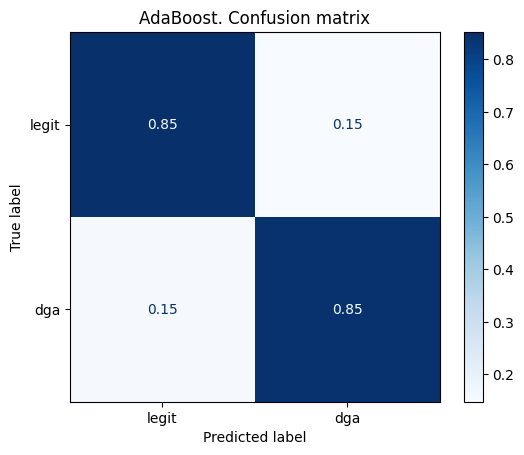

Gradient Boosting. Accuracy: 0.8485
[[0.81926514 0.18073486]
 [0.12185297 0.87814703]]


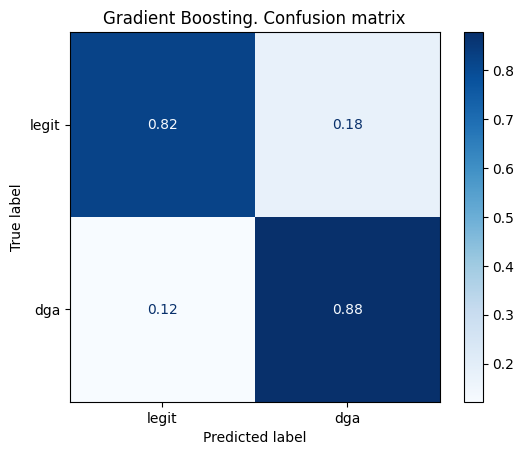

MLP. Accuracy: 0.936
[[0.95034757 0.04965243]
 [0.07854985 0.92145015]]


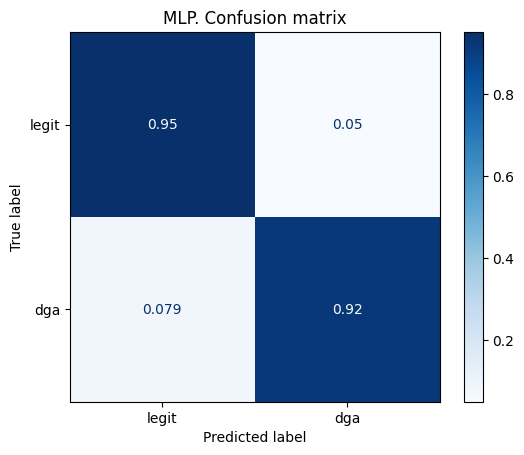

In [16]:
#train e test dei classificatori

for name, classif in zip(names[-3:], classifiers[-3:]):
    #Negli esempi di sklearn in cui confronta i classificatori usa standardscaler per standardizzare le feature
    #non so dire se serve, per ora faccio come là
    '''Dalla doc di StandardScaler(): Standardize features by removing the mean and scaling to unit variance.
#Standardization of a dataset is a common requirement for many machine learning estimators: 
they might behave badly if the individual features do not more or less look like standard normally distributed data'''
    
    #classif=make_pipeline(StandardScaler(), classif)
    classif.fit(train, label_train)
    print(f"{name}. Accuracy: {classif.score(test, label_test)}")
    disp = ConfusionMatrixDisplay.from_estimator(
        classif,
        test,
        label_test,
        display_labels=["legit", "dga"],
        cmap=plt.cm.Blues,
        normalize="true",
    )
    disp.ax_.set_title(f"{name}. Confusion matrix")

    print(disp.confusion_matrix)
    plt.show()

In [27]:
#clustering
#qua non serve l'holdout no? Tanto non ho mica allenamento
true_labels=[0 if l=="legit" else 1 for l in dataset["label"]]

#kmeans
#X = StandardScaler().fit_transform(X) serve?
kmeans=KMeans(n_clusters=2)
cluster=kmeans.fit(embedded_domain_names)
pred_labels=cluster.labels_
silhouette = silhouette_score(embedded_domain_names, true_labels, metric="euclidean")
homogeneity, completeness, v_measure= homogeneity_completeness_v_measure(true_labels, pred_labels)

print("Stats KMeans:")
print(f"Silhouette: {silhouette}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")
    

C:\Users\lorti\PyCharmProjects\datascience\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Stats KMeans:
Silhouette: 0.059585362672805786
Homogeneity: 0.19704059874937158
Completeness: 0.27842185625148685
V-measure: 0.23076652502711445


In [38]:
#dbscan
dbscan=DBSCAN(eps=25, min_samples=95)
cluster=dbscan.fit(embedded_domain_names)
pred_labels=cluster.labels_
print(pred_labels)
print(set(pred_labels))
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
n_noise = list(pred_labels).count(-1)
silhouette = silhouette_score(embedded_domain_names, pred_labels, metric="euclidean")
homogeneity, completeness, v_measure= homogeneity_completeness_v_measure(true_labels, pred_labels)

print("Stats DBScan:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Silhouette: {silhouette}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")
    

[0 0 0 ... 0 0 0]
{0}


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)